In [37]:
from sklearn.datasets import load_iris
import pandas as pd
import math
import numpy as np

In [38]:
#load iris dataset
data_iris = load_iris()
iris_X, iris_y = load_iris(return_X_y=True)
feature_iris = data_iris['feature_names']

In [39]:
#transform iris into dataframe
iris_X=pd.DataFrame(iris_X)
iris_y=pd.DataFrame(iris_y)

In [40]:
iris_X.rename(columns = {0:feature_iris[0],1:feature_iris[1],2:feature_iris[2],3:feature_iris[3]}, inplace = True)
iris_y.rename(columns = {0:"target"}, inplace = True) 

In [41]:
def rangeFeature(data):
    return data.min(),data.max()

In [42]:
def setRange(data):
    dataMin = []
    dataMax = []
    for index,col in enumerate(data.columns):
        tmpMin,tmpMax=rangeFeature(data[col])
        dataMin.append(tmpMin)
        dataMax.append(tmpMax)
    return dataMin,dataMax

In [43]:
def initCentroid(cluster,dimension,dataMin,dataMax):
    centroid = []
    for i in range(cluster):
        point = []
        for j in range(dimension):
            pos = np.random.uniform(dataMin[j],dataMax[j])
            point.append(pos)
        centroid.append(point)
    return centroid

In [44]:
type(iris_X.loc[0].values)

numpy.ndarray

In [45]:
def distFromCentroid(point1,point2):
    sumSquare = 0
    dimension = len(point1)
    for i in range(dimension):
        sumSquare += (point1[i]-point2[i])**2
    return sumSquare ** 0.5

In [46]:
def checkDistCentroid(centroid,data,cluster):
    distAllCentroid = []
    lenData = len(data)
    
    for i in range(cluster):
        distCentroid = []
        for j in range(lenData):
            dist = distFromCentroid(data.loc[j].values,centroid[i])
            distCentroid.append(dist)
        distAllCentroid.append(distCentroid)
    return distAllCentroid

In [47]:
def checkCluster(dist,cluster):
    mn = dist[0]
    idx = 0
    for i in range(1,cluster):
        if (mn>dist[i]):
            mn = dist[i]
            idx = i
    return idx

In [48]:
def clustering(distance,cluster,lenData):
    clusterNow = []
    for i in range(lenData):
        clusterNow.append(checkCluster(distance[i],cluster))
    return clusterNow

In [49]:
def moveCentroid(cluster,data):
    lenData = len(data)
    cntCluster = max(cluster) + 1
    centroid = []
    
    for i in range(cntCluster):
        cnt = 0
        point = [0]*len(data.columns)
        # get sum of coordinate one cluster
        for j in range(lenData):
            if (cluster[j]==i):
                cnt+=1
                for k,col in enumerate(data.columns):
                    point[k] += data.loc[j][col]
        # get average of coordinate one cluster
        for j in range(len(data.columns)):
            if (cnt != 0):
                point[j] /= cnt 
        centroid.append(point)
    return centroid

In [50]:
def kmeans(data,cluster):
    dataMin = []
    dataMax = []
    centroid = []
    distance = []
    lenData = len(data)
    clusterNow = []
    prevCluster = []
    
    # set range every columns
    dataMin,dataMax = setRange(data)
    # inisialize centroid
    centroid = initCentroid(cluster,len(data.columns),dataMin,dataMax)
    # check distance from centroid
    distance = pd.DataFrame(checkDistCentroid(centroid,data,cluster))
    # clustering
    clusterNow = clustering(distance, cluster, lenData)
    
    while(clusterNow != prevCluster):
        prevCluster = clusterNow
        centroid = moveCentroid(clusterNow,data)
        distance = pd.DataFrame(checkDistCentroid(centroid,data,cluster))
        clusterNow = clustering(distance, cluster, lenData)
    return clusterNow

In [51]:
clustering_result = kmeans(iris_X,2)
clustering_result

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [52]:
clustering_res = pd.DataFrame(clustering_result)
data = pd.concat([iris_X, clustering_res], axis=1)
data.rename(columns={0:"clustering_result"}, inplace = True)
# data

### Visualization k-means
Kami menggambar dalam 2 dimensi untuk setiap pasangan kolom (column1 dan column2) yang mungkin dari dataset yang diberikan. Kemudian hasil clustering direpresentasikan sebagai warna yang berbeda.

In [55]:
def visualization_k_means(column_name):
    for column1 in column_name:
        for column2 in column_name:
            if(column1 != column2):
                sns.lmplot(column1, column2, data=data, hue='clustering_result', fit_reg=False)
                ax = plt.gca()
                ax.set_title('Clustering Result')
                plt.show()

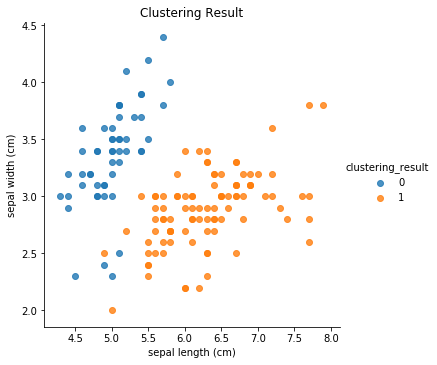

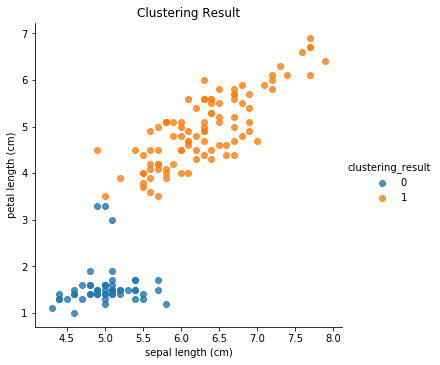

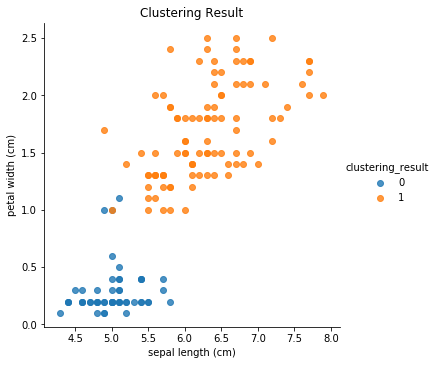

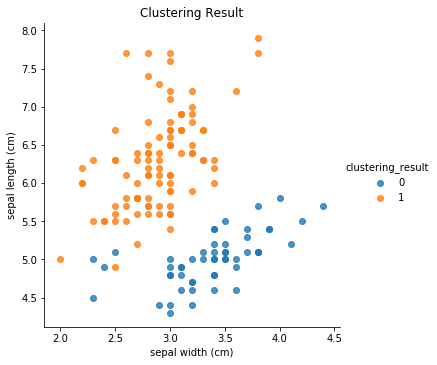

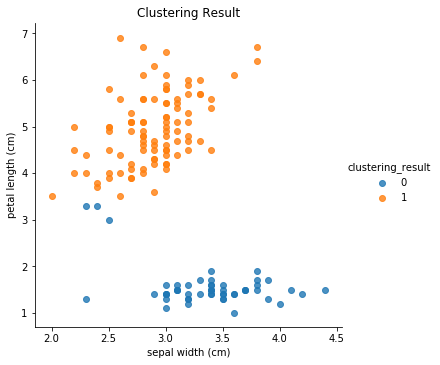

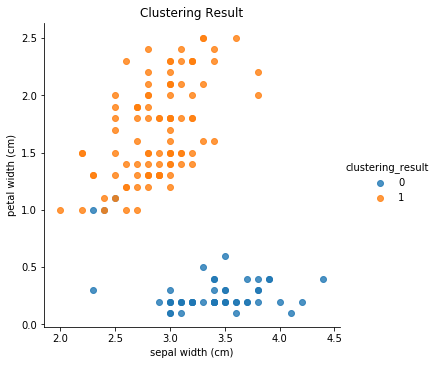

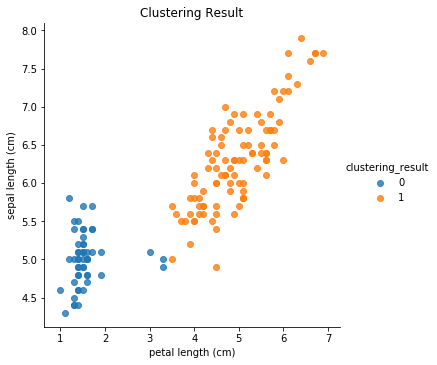

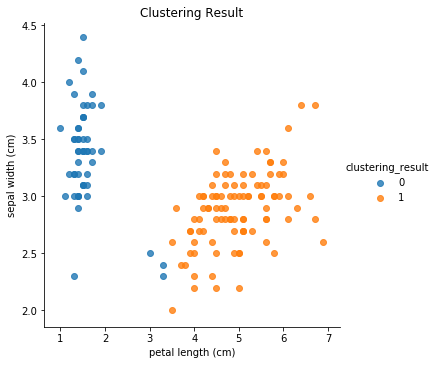

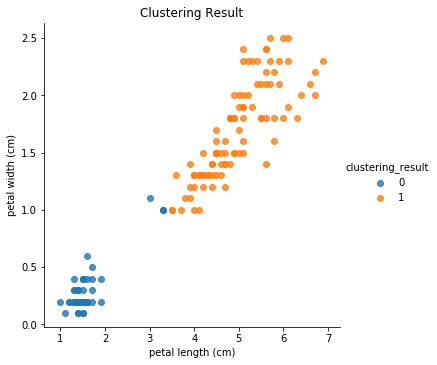

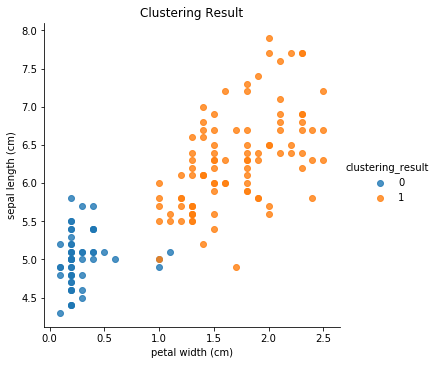

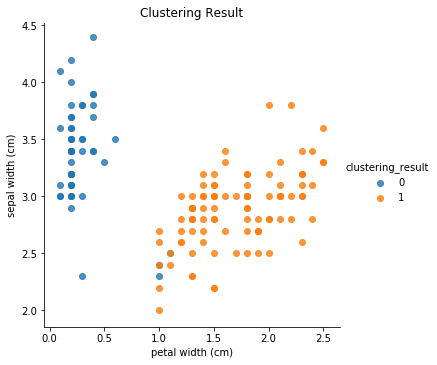

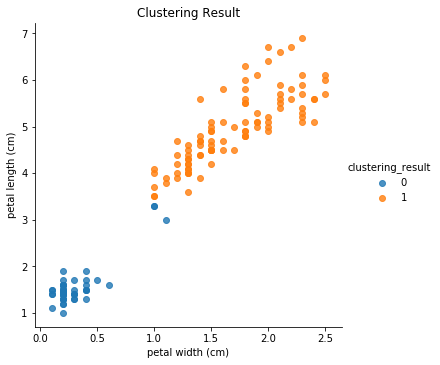

In [56]:
visualization_k_means(iris_X.columns)

In [57]:
iris_X.loc[145].values

array([6.7, 3. , 5.2, 2.3])

In [58]:
def euclidean_dist(point1, point2):
    distance = 0
    dimension = len(point1)
    
    for i in range(dimension):
        distance += (point1[i]-point2[i])**2
        
    return distance ** 0.5

In [59]:
def init_proximity_matrix(data):
    matrix = [[0 for i in range(len(data))] for j in range(len(data))]
    
    for i in range(len(data)):
        for j in range(i, len(data)):
            if (i != j):
                proximity = euclidean_dist(data.loc[i].values, data.loc[j].values)
                matrix[i][j] = proximity
                matrix[j][i] = proximity
    
    return matrix

In [60]:
def init_cluster(n_cluster):
    clusters = []
    
    for i in range(n_cluster):
        clusters.append(str(i))
        
    return clusters

In [61]:
def find_shortest_dist(proximity_matrix):
    min_distance = float("inf")
    result = [0, 1]
    
    for i in range(len(proximity_matrix)):
        for j in range(i, len(proximity_matrix)):
            if (proximity_matrix[i][j] > 0) and (proximity_matrix[i][j] < min_distance):
                min_distance = proximity_matrix[i][j]
                print(min_distance)
                result[0] = i
                result[1] = j
    
    return result

In [62]:
def update_clusters(clusters, cluster1, cluster2):
    updated_clusters = []
    
    for i in range(len(clusters)-1):
        if (i != cluster1):
            if (i >= cluster2):
                updated_clusters.append(clusters[i+1])
            else:
                updated_clusters.append(clusters[i])
        else:
            updated_clusters.append(clusters[cluster1] + "," + clusters[cluster2])
    
    return updated_clusters

In [63]:
def update_proximity_matrix(matrix, cluster1, cluster2, linkage):
    updated_matrix = [[0 for i in range(len(matrix)-1)] for j in range(len(matrix)-1)]

    for i in range(len(updated_matrix)):
        if (i != cluster1):
            idx_i = i
            if (i >= cluster2):
                idx_i += 1

            for j in range(idx_i, len(updated_matrix)):
                if (i != j):
                    if (j != cluster1):
                        if (j >= cluster2):
                            updated_matrix[i][j] = matrix[idx_i][j+1]
                            updated_matrix[j][i] = matrix[idx_i][j+1]
                        else:
                            updated_matrix[i][j] = matrix[idx_i][j]
                            updated_matrix[j][i] = matrix[idx_i][j]
                    else:
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                            updated_matrix[j][i] = min([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                            updated_matrix[j][i] = max([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])

        else:
            for j in range(i, len(updated_matrix)):
                if (i != j):
                    if (j >= cluster2):
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                            updated_matrix[j][i] = min([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                            updated_matrix[j][i] = max([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                    else:
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[cluster1][j], matrix[cluster2][j]]) 
                            updated_matrix[j][i] = min([matrix[cluster1][j], matrix[cluster2][j]]) 
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[cluster1][j], matrix[cluster2][j]]) 
                            updated_matrix[j][i] = max([matrix[cluster1][j], matrix[cluster2][j]]) 
                        
    return updated_matrix

In [64]:
def agglomerative(data, cluster, linkage):
    n_cluster = len(data)
    proximity_matrix = init_proximity_matrix(data)
    clusters = init_cluster(n_cluster)
#     n_cluster = 6
#     proximity_matrix = [[0.00, 0.71, 5.66, 3.61, 4.24, 3.20], [0.71, 0.00, 4.95, 2.92, 3.54, 2.50], [5.66, 4.95, 0.00, 2.24, 1.41, 2.50], [3.61, 2.92, 2.24, 0.00, 1.00, 0.50], [4.24, 3.54, 1.41, 1.00, 0.00, 1.12], [3.20, 2.50, 2.50, 0.50, 1.12, 0.00]]
#     clusters = ['a', 'b', 'c', 'd', 'e', 'f']
#     n_cluster = 4
#     proximity_matrix = [[0, 1, 4, 5], [1, 0, 2, 6], [4, 2, 0, 3], [5, 6, 3, 0]]
#     clusters = ['a', 'b', 'c', 'd']
    
    if (len(data) > 1):
        while (n_cluster > cluster):             
            cluster_pair = find_shortest_dist(proximity_matrix)
#             print(cluster_pair)
#             print(proximity_matrix)
#             print(clusters)
            clusters = update_clusters(clusters, cluster_pair[0], cluster_pair[1])  
            proximity_matrix = update_proximity_matrix(proximity_matrix, cluster_pair[0], cluster_pair[1], linkage)

            n_cluster -= 1
    
    return clusters

In [65]:
print(agglomerative(iris_X, 1, "complete"))

0.5385164807134502
0.509901951359278
0.1414213562373093
0.09999999999999998
0.09999999999999964
0.5385164807134502
0.509901951359278
0.1414213562373093
0.09999999999999998
0.5477225575051659
0.5196152422706627
0.17320508075688756
0.17320508075688743
0.1414213562373099
0.14142135623730964
0.14142135623730925
0.1
0.5477225575051659
0.5196152422706627
0.17320508075688756
0.17320508075688743
0.1414213562373099
0.14142135623730986
0.14142135623730978
0.14142135623730964
0.14142135623730925
0.10000000000000053
0.10000000000000009
0.5477225575051659
0.5196152422706627
0.17320508075688756
0.17320508075688743
0.1414213562373099
0.14142135623730986
0.14142135623730978
0.14142135623730964
0.14142135623730925
0.10000000000000053
0.5477225575051659
0.5196152422706627
0.17320508075688756
0.17320508075688743
0.1414213562373099
0.14142135623730986
0.14142135623730978
0.14142135623730964
0.14142135623730925
0.5477225575051659
0.5196152422706627
0.29999999999999954
0.1999999999999999
0.17320508075688806